In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction
import glob

In [2]:
dataPath = "MLProject/data/"
os.listdir(dataPath)

['Cardboard',
 'Food Organics',
 'Glass',
 'Metal',
 'Miscellaneous Trash',
 'Paper',
 'Plastic',
 'Textile Trash',
 'Vegetation']

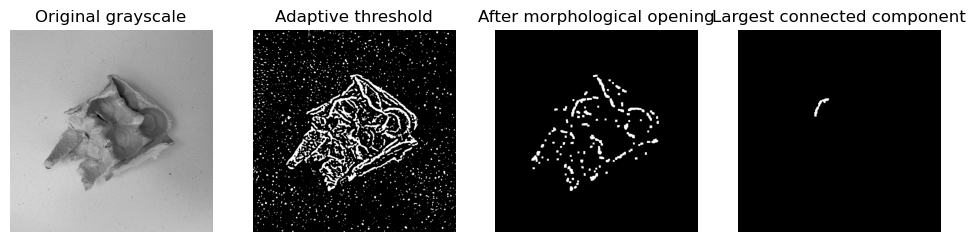

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess
img_path = './MLProject/data/Cardboard/Cardboard_16.jpg'
gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(gray, (7,7), 0)

# Adaptive threshold
binary = cv2.adaptiveThreshold(
    blurred, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY_INV,
    blockSize = 15,
    C = 2
)

# Morph open to clean specks
kernel = np.ones((3,3), np.uint8)
cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

# Keep largest blob
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(cleaned, connectivity=8)
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
mask_largest = np.uint8(labels == largest_label) * 255

# Plot steps
plt.figure(figsize=(12,6))
plt.subplot(1,4,1)
plt.imshow(gray, cmap='gray')
plt.title("Original grayscale")
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(binary, cmap='gray')
plt.title("Adaptive threshold")
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(cleaned, cmap='gray')
plt.title("After morphological opening")
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(mask_largest, cmap='gray')
plt.title("Largest connected component")
plt.axis('off')

plt.show()


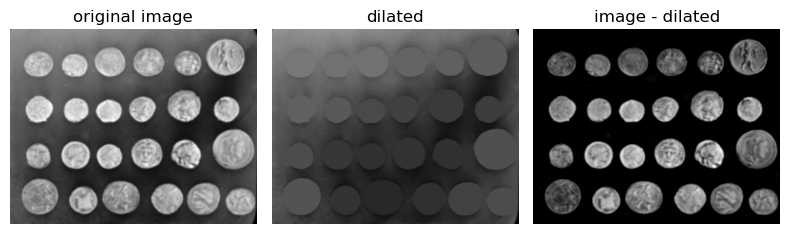

In [3]:
fig, (ax0, ax1, ax2) = plt.subplots(
    nrows=1, ncols=3, figsize=(8, 2.5), sharex=True, sharey=True
)

ax0.imshow(image, cmap='gray')
ax0.set_title('original image')
ax0.axis('off')

ax1.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap='gray')
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(image - dilated, cmap='gray')
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()

In [3]:
a = "Paper_259.jpg"
int(a.strip(".jpg").split("_")[1])

259

In [ ]:
dataPath = "MLProject/data/"

df = pd.DataFrame(columns = ["category", "indexInCategory", "filePath"])

counter = 0
for folderName in os.listdir(dataPath):
    folderPath  = os.path.join(dataPath, folderName)
    for fileName in os.listdir(folderPath):
        
        filePath = os.path.join(folderPath, fileName)
        category = folderName
        indexInCategory = int(fileName.strip(".jpg").split("_")[1])
        
        df.loc[counter] = [category, indexInCategory, filePath]
        counter += 1

        
outputFile = "data.csv"

if os.path.exists(outputFile):
    os.remove(outputFile)
    
df.to_csv(outputFile, index=False)       
    

In [ ]:
    """
    Open image,
    detect objects,
    add to check_area
    next image
    check_area
    if check_area is full
        continue
    else
        update area with both old and new area
    """

In [ ]:
# CONFIG
IMAGE_FOLDER = './MLProject/data/Cardboard/'
PIXEL_THRESHOLD = 5000  # When this many pixels are in check_area, it's considered "full"

def get_object_pixel_coords(image):
    """Return a list of (i, j) coordinates where object pixels are detected."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY_INV)  # Invert: object=white
    object_pixels = np.argwhere(mask > 0)  # mask shape: (512, 512)
    return [tuple(coord) for coord in object_pixels]

def main():
    image_files = sorted(f for f in os.listdir(IMAGE_FOLDER) if f.lower().endswith(('.png', '.jpg', '.jpeg')))
    check_area = set()
    check_area_list = []
    check_area_count = 0

    for img_file in image_files:
        image_path = os.path.join(IMAGE_FOLDER, img_file)
        image = cv2.imread(image_path)

        object_coords = get_object_pixel_coords(image)

        check_area.update(object_coords)

        if len(check_area) >= PIXEL_THRESHOLD:
            # Save or print the pixel coordinates of this check_area
            check_area_list.append(list(check_area))
            print(f"Check area #{check_area_count} full with {len(check_area)} object pixels.")
            check_area_count += 1
            check_area = set()  # Start a new area

    # Final remaining check_area
    if check_area:
        check_area_list.append(list(check_area))
        print(f"Final check area #{check_area_count} saved with {len(check_area)} object pixels.")

    # Example: save all check areas as numpy arrays (optional)
    for idx, coords in enumerate(check_area_list):
        coords_array = np.array(coords)
        np.save(f'check_area_coords_{idx}.npy', coords_array)
        print(f"Saved check_area_coords_{idx}.npy")

if __name__ == '__main__':
    main()


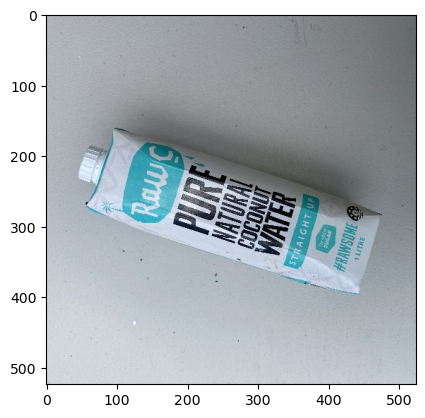

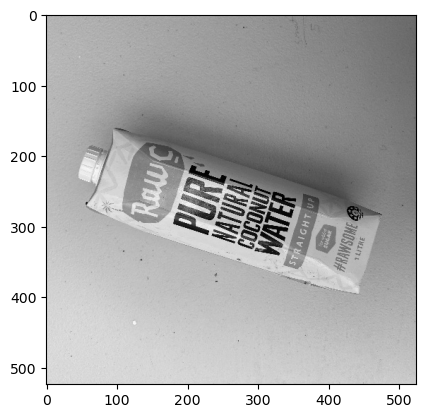

In [12]:
img = cv2.imread("MLProject/data/Cardboard/Cardboard_20.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_rgb)
plt.show()
plt.imshow(img_gray, cmap='gray')
plt.show()

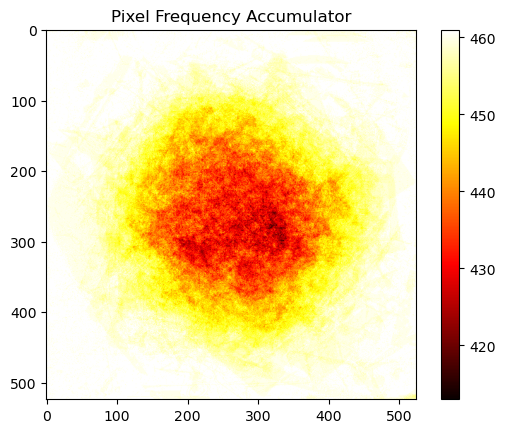

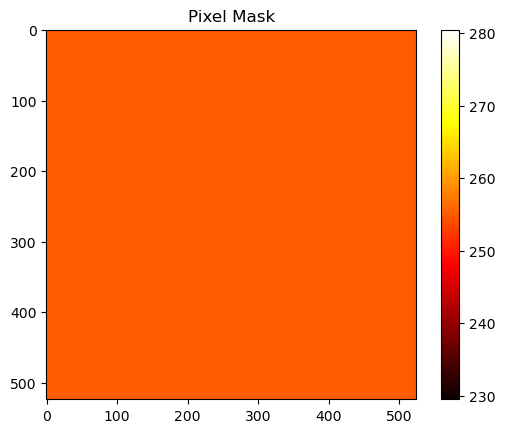

Common ROI bounding box: x=0, y=0, w=524, h=524


In [20]:
import numpy as np
import cv2
import glob

# Load all images
paths = glob.glob('./MLProject/data/Cardboard/*.jpg')  # or .png
accumulator = np.zeros((524, 524), dtype=np.float32)

for path in paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # Simple threshold to detect non-background pixels
    _, binary = cv2.threshold(img, 30, 1, cv2.THRESH_BINARY)  # adjust threshold
    accumulator += binary

# Normalize to get frequency heatmap
heatmap = accumulator / len(paths)

plt.imshow(accumulator, cmap='hot')
plt.colorbar()
plt.title("Pixel Frequency Accumulator")
plt.show()

# Threshold heatmap to get common region mask
_, mask = cv2.threshold(heatmap, 0.2, 1, cv2.THRESH_BINARY)  # 20% threshold

# Convert to uint8 for contour finding
mask_uint8 = (mask * 255).astype(np.uint8)

plt.imshow(mask_uint8, cmap='hot')
plt.colorbar()
plt.title("Pixel Mask")
plt.show()

# Find bounding box
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
x, y, w, h = cv2.boundingRect(contours[0])

print(f"Common ROI bounding box: x={x}, y={y}, w={w}, h={h}")

# Now crop images using this box


In [38]:
import numpy as np
import cv2
import glob

# Load all images
paths = glob.glob('RealWaste/*.jpg')
accumulator = np.zeros((524, 524), dtype=np.float32)

background_threshold = 220  # tune this!

for path in paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # Since background is white, object is darker
    binary = (img < background_threshold).astype(np.float32)
    accumulator += binary

# Normalize by number of images to get probability map
heatmap = accumulator / len(paths)


/tmp/ipykernel_1456/2038680246.py:18: RuntimeWarning: invalid value encountered in divide
  heatmap = accumulator / len(paths)


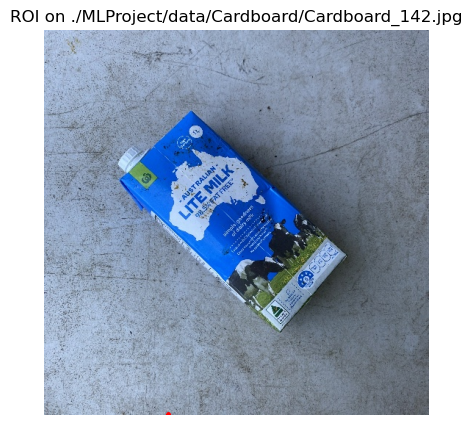

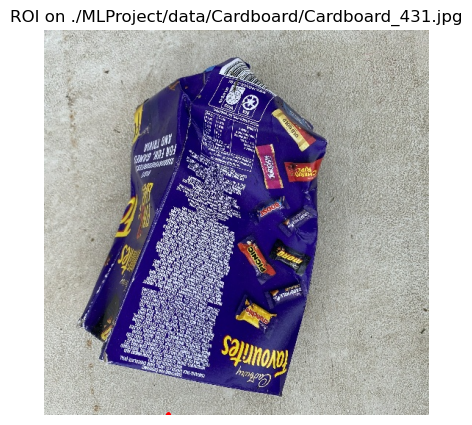

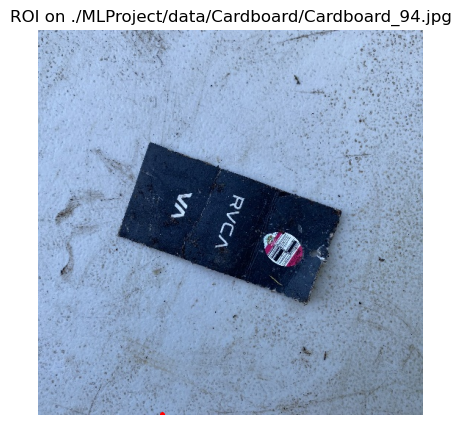

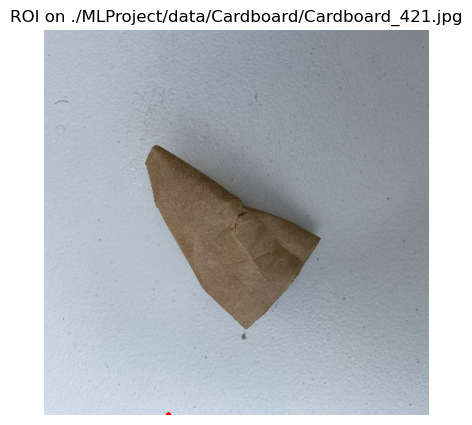

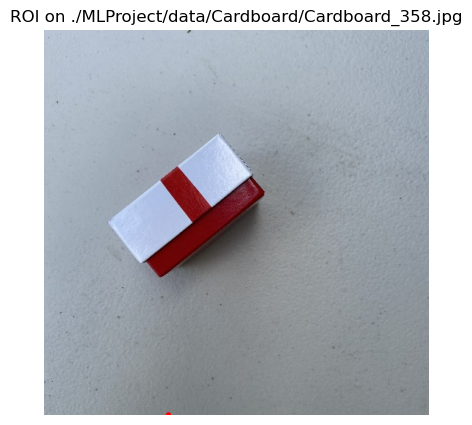

In [39]:
import random
image_paths = glob.glob('./MLProject/data/Cardboard/*.jpg')
sample_paths = random.sample(image_paths, 5)

for path in sample_paths:
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.rectangle(img_rgb, (x, y), (x+w, y+h), (255, 0, 0), 3)
    
    plt.figure(figsize=(5,5))
    plt.imshow(img_rgb)
    plt.title(f"ROI on {path}")
    plt.axis('off')
    plt.show()


Processing 461 images of size 524x524


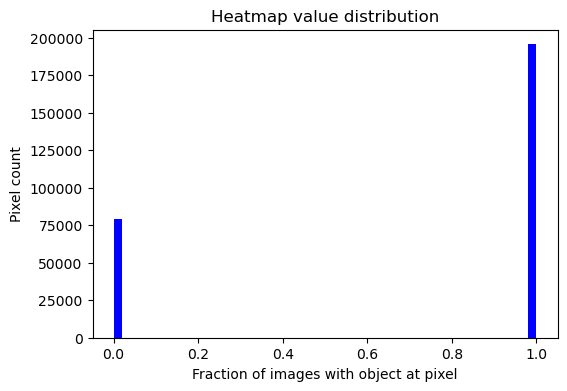

Common ROI bounding box: x=168, y=522, w=2, h=1


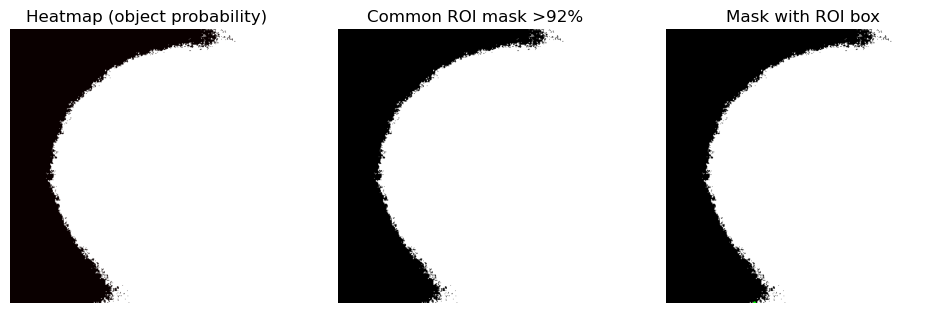

Visualizing ROI overlay on sample images...


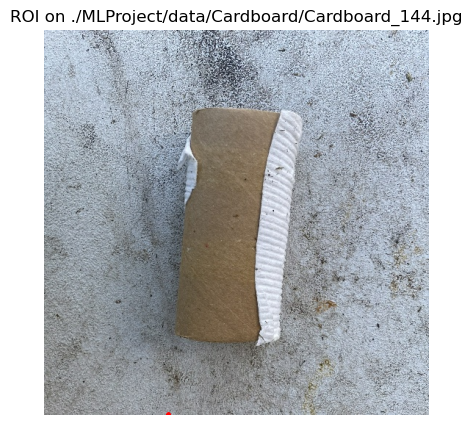

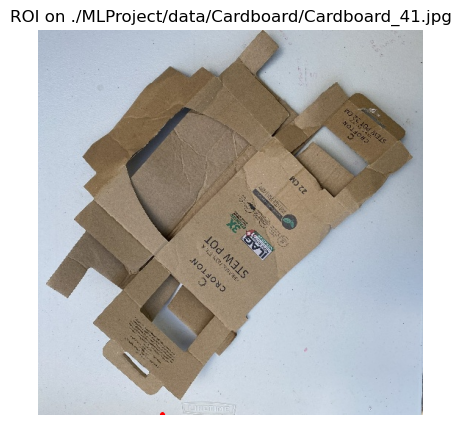

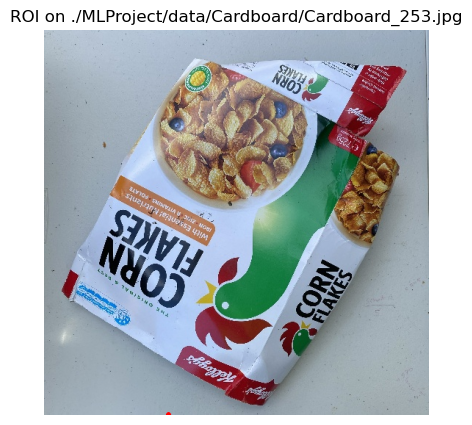

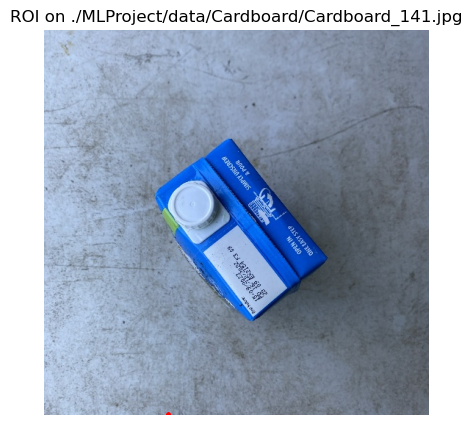

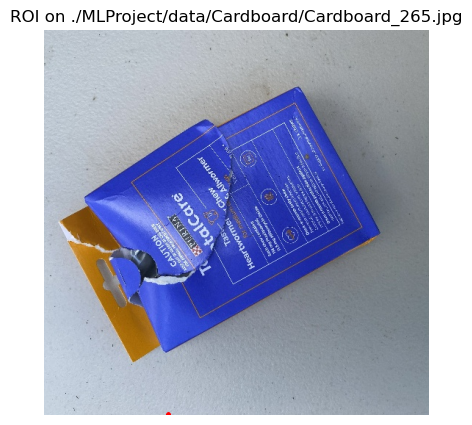

In [37]:
import cv2
import numpy as np
import glob
import random
import matplotlib.pyplot as plt

# -----------------------------
# Parameters
# -----------------------------
background_threshold = 180     # stricter to avoid counting slightly gray backgrounds
roi_occurrence_threshold = 0.92  # % images that must have object here
use_median = True  # set False to use average

kernel_size = 3  # for morphological cleaning

# -----------------------------
# Load images & create masks
# -----------------------------
image_paths = glob.glob('./MLProject/data/Cardboard/*.jpg')
assert len(image_paths) > 0, "No images found!"

sample_img = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)
H = 524
W = 524
all_masks = []

print(f"Processing {len(image_paths)} images of size {W}x{H}")

kernel = np.ones((kernel_size, kernel_size), np.uint8)

for path in image_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    binary_mask = (img < background_threshold).astype(np.uint8)
    # morphological opening to remove noise
    cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    all_masks.append(cleaned_mask)

stack = np.stack(all_masks, axis=0)  # shape (N,H,W)

# -----------------------------
# Compute heatmap
# -----------------------------
if use_median:
    heatmap = np.median(stack, axis=0)
else:
    heatmap = np.mean(stack, axis=0)

# -----------------------------
# Histogram of heatmap values
# -----------------------------
plt.figure(figsize=(6,4))
plt.hist(heatmap.ravel(), bins=50, color='blue')
plt.title('Heatmap value distribution')
plt.xlabel('Fraction of images with object at pixel')
plt.ylabel('Pixel count')
plt.show()

# -----------------------------
# Threshold heatmap to get common ROI mask
# -----------------------------
_, mask = cv2.threshold(heatmap, roi_occurrence_threshold, 1, cv2.THRESH_BINARY)
mask_uint8 = (mask * 255).astype(np.uint8)

# -----------------------------
# Find bounding box
# -----------------------------
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if len(contours) == 0:
    raise ValueError("No common ROI found — try lowering roi_occurrence_threshold or using different background_threshold.")

x, y, w, h = cv2.boundingRect(contours[0])
print(f"Common ROI bounding box: x={x}, y={y}, w={w}, h={h}")

# -----------------------------
# Visualize heatmap + mask + bbox
# -----------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(heatmap, cmap='hot')
plt.title('Heatmap (object probability)')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask, cmap='gray')
plt.title(f'Common ROI mask >{roi_occurrence_threshold*100:.0f}%')
plt.axis('off')

bbox_img = cv2.cvtColor((mask * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
cv2.rectangle(bbox_img, (x,y), (x+w,y+h), (0,255,0), 2)
plt.subplot(1,3,3)
plt.imshow(bbox_img)
plt.title('Mask with ROI box')
plt.axis('off')
plt.show()

# -----------------------------
# Overlay ROI box on random images
# -----------------------------
print("Visualizing ROI overlay on sample images...")
sample_paths = random.sample(image_paths, min(5, len(image_paths)))
for path in sample_paths:
    img_bgr = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    cv2.rectangle(img_rgb, (x,y), (x+w,y+h), (255,0,0), 3)
    plt.figure(figsize=(5,5))
    plt.imshow(img_rgb)
    plt.title(f'ROI on {path}')
    plt.axis('off')
    plt.show()


In [41]:
import cv2
import numpy as np

# ---------------------------
# Load single image in grayscale
# ---------------------------
img_path = './MLProject/data/Food Organics/Food Organics_6.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
H, W = img.shape
print(f"Loaded image of size: {W}x{H}")

# ---------------------------
# Split into 8x8 grid
# ---------------------------
grid_rows = 8
grid_cols = 8

cell_h = H // grid_rows
cell_w = W // grid_cols

average_brightness = np.zeros((grid_rows, grid_cols), dtype=np.float32)

# ---------------------------
# Compute average brightness
# ---------------------------
for i in range(grid_rows):
    for j in range(grid_cols):
        y_start = i * cell_h
        y_end = (i + 1) * cell_h if i < grid_rows - 1 else H
        x_start = j * cell_w
        x_end = (j + 1) * cell_w if j < grid_cols - 1 else W
        
        cell = img[y_start:y_end, x_start:x_end]
        avg = np.mean(cell)
        average_brightness[i, j] = avg

# ---------------------------
# Print results
# ---------------------------
np.set_printoptions(precision=1, suppress=True)
print("\nAverage brightness (0-255) per grid cell:")
print(average_brightness)


Loaded image of size: 524x524

Average brightness (0-255) per grid cell:
[[174.  171.7 171.8 170.3 168.1 168.8 170.8 168.9]
 [166.3 170.  166.4 163.3 164.1 165.7 167.7 168.4]
 [167.7 167.4 166.2 163.7 151.  154.7 162.1 159.1]
 [162.3 164.4 160.3 141.1 140.4 136.1 156.7 154.5]
 [160.7 159.8 156.4 128.4 114.1 127.2 149.3 144.7]
 [159.  152.1 151.7 124.5 124.1 141.4 136.3 134. ]
 [150.7 144.4 142.1 139.8 136.3 133.3 128.7 119.9]
 [139.5 130.3 132.1 124.9 121.8 118.4 111.2 106.9]]
